***DRIVE MOUNT***






In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


***AUGMENTATION OF THE DATASET***

In [ ]:
# Augmentation
import os
import random
from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- Configuration ---
# Set the path to your dataset folder in Google Drive
base_dataset_path = '/content/drive/MyDrive/Thesis/dataset' # <-- IMPORTANT: Check this path is correct

# Define the folders for each class
class_folders = {
    'acnes': 'acnes',
    'hyperpigmentation': 'hyperpigmentation',
    'Nail_psoriasis': 'Nail_psoriasis',
    'SJS-TEN': 'SJS-TEN',
    'Vitiligo': 'Vitiligo' # <-- Double-check this name matches your folder exactly
}

# The target number of images per class
target_image_count = 2000

# --- Augmentation Setup ---
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# --- Main Loop ---
for class_name, folder_name in class_folders.items():
    folder_path = os.path.join(base_dataset_path, folder_name)

    # --- ⭐️ ERROR FIX: Check if the folder exists ---
    if not os.path.isdir(folder_path):
        print(f"🚨 ERROR: Directory not found for class '{class_name}': {folder_path}. Skipping.")
        continue

    # Get the list of all images in the folder
    images = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    num_images = len(images)

    print(f"\nProcessing '{class_name}': Found {num_images} images.")

    # --- Logic to Increase, Decrease, or Skip ---
    if num_images < target_image_count:
        # --- AUGMENTATION (INCREASE) LOGIC ---
        num_to_generate = target_image_count - num_images
        print(f"Augmenting '{class_name}': Generating {num_to_generate} new images...")

        # Select random images from the folder to augment
        images_to_augment = random.choices(images, k=num_to_generate)

        for image_name in images_to_augment:
            image_path = os.path.join(folder_path, image_name)
            try:
                img = Image.open(image_path).convert('RGB')
                img = img.resize((224, 224))
                x = np.array(img)
                x = x.reshape((1,) + x.shape)

                # Generate one augmented image
                for batch in datagen.flow(x, batch_size=1):
                    augmented_image = Image.fromarray(batch[0].astype('uint8'))
                    new_image_name = f"aug_{random.randint(10000, 99999)}_{image_name}"
                    augmented_image.save(os.path.join(folder_path, new_image_name))
                    break # Stop after one is generated
            except Exception as e:
                print(f"Could not process image {image_name}. Error: {e}")

    elif num_images > target_image_count:
        # --- ⭐️ NEW: DECREASE LOGIC ---
        num_to_delete = num_images - target_image_count
        print(f"Decreasing '{class_name}': Randomly deleting {num_to_delete} images...")

        # Randomly select images to delete
        images_to_delete = random.sample(images, num_to_delete)

        for image_name in images_to_delete:
            file_to_delete_path = os.path.join(folder_path, image_name)
            try:
                os.remove(file_to_delete_path)
            except Exception as e:
                print(f"Could not delete image {image_name}. Error: {e}")

    else: # num_images == target_image_count
        print(f"'{class_name}' already has {target_image_count} images. No action needed.")


print("\nProcessing complete! ✅")



Processing 'acnes': Found 1156 images.
Augmenting 'acnes': Generating 844 new images...

Processing 'hyperpigmentation': Found 2000 images.
'hyperpigmentation' already has 2000 images. No action needed.

Processing 'Nail_psoriasis': Found 2000 images.
'Nail_psoriasis' already has 2000 images. No action needed.

Processing 'SJS-TEN': Found 2000 images.
'SJS-TEN' already has 2000 images. No action needed.

Processing 'Vitiligo': Found 2000 images.
'Vitiligo' already has 2000 images. No action needed.

Processing complete! ✅


**DATA SPLITTING IN 70% 15% 15% FORMAT **

In [ ]:
import os
import random
import shutil

# --- Configuration ---
# Path to your balanced dataset (where each class has 2000 images)
source_dataset_path = '/content/drive/MyDrive/Thesis/dataset' # <-- IMPORTANT: Path to your processed dataset

# Path where the new split dataset will be created
output_dataset_path = '/content/drive/MyDrive/Thesis/Split_Dataset'

# Define the split ratios
# 70% for training, 15% for validation, 15% for testing
split_ratios = (0.7, 0.15, 0.15)

# --- Main Splitting Logic ---
print("Starting dataset split...")

# Create the main output directories (train, validation, test)
if os.path.exists(output_dataset_path):
    shutil.rmtree(output_dataset_path) # Remove old directory to ensure a clean split
    print(f"Removed existing directory at: {output_dataset_path}")

train_dir = os.path.join(output_dataset_path, 'train')
validation_dir = os.path.join(output_dataset_path, 'validation')
test_dir = os.path.join(output_dataset_path, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get the list of class folders from the source directory
class_names = [d for d in os.listdir(source_dataset_path) if os.path.isdir(os.path.join(source_dataset_path, d))]

# Loop through each class folder
for class_name in class_names:
    print(f"\nProcessing class: {class_name}")

    # Create class-specific subdirectories in train, validation, and test folders
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(validation_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Get all image file names for the current class
    source_class_dir = os.path.join(source_dataset_path, class_name)
    all_files = [f for f in os.listdir(source_class_dir) if os.path.isfile(os.path.join(source_class_dir, f))]

    # Shuffle the files randomly for an unbiased split
    random.shuffle(all_files)

    # Calculate split indices
    total_files = len(all_files)
    train_end = int(total_files * split_ratios[0])
    validation_end = train_end + int(total_files * split_ratios[1])

    # Slice the list of files into the three sets
    train_files = all_files[:train_end]
    validation_files = all_files[train_end:validation_end]
    test_files = all_files[validation_end:]

    # --- Function to copy files ---
    def copy_files(files, source_dir, dest_dir):
        for f in files:
            shutil.copy(os.path.join(source_dir, f), os.path.join(dest_dir, f))

    # Copy files to their new destination
    copy_files(train_files, source_class_dir, os.path.join(train_dir, class_name))
    copy_files(validation_files, source_class_dir, os.path.join(validation_dir, class_name))
    copy_files(test_files, source_class_dir, os.path.join(test_dir, class_name))

    print(f"  - Training set:   {len(train_files)} images")
    print(f"  - Validation set: {len(validation_files)} images")
    print(f"  - Testing set:    {len(test_files)} images")

print("\nDataset splitting complete! ✅")


Starting dataset split...
Removed existing directory at: /content/drive/MyDrive/Thesis/Split_Dataset

Processing class: Nail_psoriasis
  - Training set:   1400 images
  - Validation set: 300 images
  - Testing set:    300 images

Processing class: Vitiligo
  - Training set:   1400 images
  - Validation set: 300 images
  - Testing set:    300 images

Processing class: SJS-TEN
  - Training set:   1400 images
  - Validation set: 300 images
  - Testing set:    300 images

Processing class: acnes
  - Training set:   1400 images
  - Validation set: 300 images
  - Testing set:    300 images

Processing class: hyperpigmentation
  - Training set:   1400 images
  - Validation set: 300 images
  - Testing set:    300 images

Dataset splitting complete! ✅


**InceptionV3 Model**

Found 7000 images belonging to 5 classes.
Found 1500 images belonging to 5 classes.
Found 1500 images belonging to 5 classes.
Found 5 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

--- Starting Initial Training (Feature Extraction) ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.5212 - loss: 1.4975 - val_accuracy: 0.8087 - val_loss: 0.4850
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.7753 - loss: 0.6006 - val_accuracy: 0.8627 - val_loss: 0.3921
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - accuracy: 0.8205 - loss: 0.4832 - val_accuracy: 0.8647 - val_loss: 0.3728
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.8283 - loss: 0.4567 - val_accuracy: 0.8887 - val_loss: 0.3277
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.8349 - loss: 0.4222 - val_accuracy: 0.8887 - val_loss: 0.3165
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - accuracy: 0.8397 - loss: 0.4247 - val_accuracy: 0.8980 - val_loss: 0.2927
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - accuracy: 0.8595 - loss: 0.3858 - val_accuracy: 0.8933 - val_loss: 0.2858
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - accuracy: 0.8730 - loss: 0.3529 - val_accu

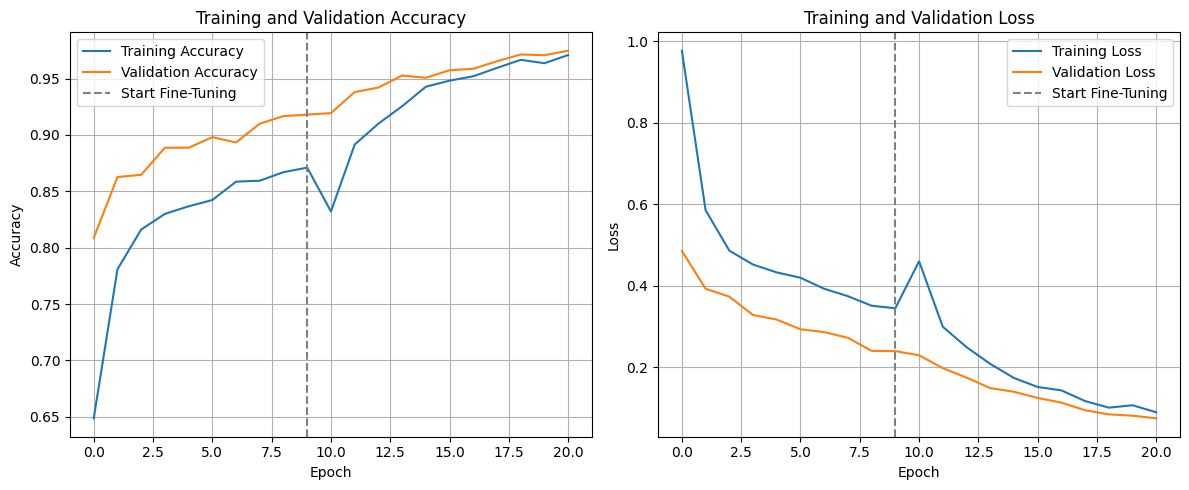

In [ ]:
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import InceptionV3

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

import os

# --- 1. Configuration and Setup ---

# Define paths to your split dataset

base_dir = '/content/drive/MyDrive/Thesis/Split_Dataset'

train_dir = os.path.join(base_dir, 'train')

validation_dir = os.path.join(base_dir, 'validation')

test_dir = os.path.join(base_dir, 'test')

# Model parameters

# IMPORTANT: InceptionV3 expects 299x299 images

IMG_HEIGHT = 299

IMG_WIDTH = 299

BATCH_SIZE = 64 # You can adjust this based on your GPU memory (e.g., 16, 64)

INITIAL_EPOCHS = 10

FINE_TUNE_EPOCHS = 10

TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS

# --- 2. Data Loading and Preprocessing ---

# Create ImageDataGenerators with InceptionV3-specific preprocessing

# The training generator includes data augmentation

train_datagen = ImageDataGenerator(

    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,

    rotation_range=40,

    width_shift_range=0.2,

    height_shift_range=0.2,

    shear_range=0.2,

    zoom_range=0.2,

    horizontal_flip=True,

    fill_mode='nearest'

)

# Validation and Test generators should only have preprocessing

validation_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)

test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)

# Create data generators from directories

train_generator = train_datagen.flow_from_directory(

    train_dir,

    target_size=(IMG_HEIGHT, IMG_WIDTH),

    batch_size=BATCH_SIZE,

    class_mode='sparse'

)

validation_generator = validation_datagen.flow_from_directory(

    validation_dir,

    target_size=(IMG_HEIGHT, IMG_WIDTH),

    batch_size=BATCH_SIZE,

    class_mode='sparse'

)

test_generator = test_datagen.flow_from_directory(

    test_dir,

    target_size=(IMG_HEIGHT, IMG_WIDTH),

    batch_size=BATCH_SIZE,

    class_mode='sparse',

    shuffle=False # Do not shuffle test data

)

# Get the number of classes

num_classes = train_generator.num_classes

print(f"Found {num_classes} classes.")

# --- 3. Model Building (Transfer Learning with InceptionV3) ---

# Load the InceptionV3 base model, pre-trained on ImageNet

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze the base model layers

base_model.trainable = False

# Create our custom classifier head

x = base_model.output

x = GlobalAveragePooling2D()(x) # Averages the features

x = Dense(1024, activation='relu')(x) # A larger dense layer can be useful

x = Dropout(0.5)(x) # Dropout for regularization

predictions = Dense(num_classes, activation='softmax')(x) # Final output layer

# Combine the base model and our custom head

model = Model(inputs=base_model.input, outputs=predictions)

# --- 4. Compile and Train (Feature Extraction Phase) ---

model.compile(optimizer=Adam(learning_rate=0.001),

              loss='sparse_categorical_crossentropy',

              metrics=['accuracy'])

print("\n--- Starting Initial Training (Feature Extraction) ---")

history = model.fit(

    train_generator,

    epochs=INITIAL_EPOCHS,

    validation_data=validation_generator

)

# --- 5. Fine-Tuning Phase ---

print("\n--- Starting Fine-Tuning ---")

# Unfreeze some of the top layers of the base model

base_model.trainable = True

# InceptionV3 has 311 layers. Let's unfreeze from layer 249 onwards.

# This fine-tunes the top 2 inception blocks.

fine_tune_at = 249

# Freeze all layers before the `fine_tune_at` layer

for layer in base_model.layers[:fine_tune_at]:

    layer.trainable = False

# Re-compile the model with a very low learning rate for fine-tuning

model.compile(optimizer=Adam(learning_rate=1e-5),

              loss='sparse_categorical_crossentropy',

              metrics=['accuracy'])

# Continue training the model

history_fine = model.fit(

    train_generator,

    epochs=TOTAL_EPOCHS,

    initial_epoch=history.epoch[-1],

    validation_data=validation_generator

)

# --- 6. Final Evaluation on the Test Set ---

print("\n--- Evaluating Model on Test Data ---")

test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Accuracy: {test_accuracy*100:.2f}%")

print(f"Test Loss: {test_loss:.4f}")

# --- 7. Plotting Training History ---

# Combine the history from both training phases

acc = history.history['accuracy'] + history_fine.history['accuracy']

val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

loss = history.history['loss'] + history_fine.history['loss']

val_loss = history.history['val_loss'] + history_fine.history['val_loss']

# Create plots

plt.figure(figsize=(12, 5))

# Plot Accuracy

plt.subplot(1, 2, 1)

plt.plot(acc, label='Training Accuracy')

plt.plot(val_acc, label='Validation Accuracy')

plt.axvline(INITIAL_EPOCHS - 1, color='gray', linestyle='--', label='Start Fine-Tuning')

plt.title('Training and Validation Accuracy')

plt.xlabel('Epoch')

plt.ylabel('Accuracy')

plt.legend()

plt.grid(True)

# Plot Loss

plt.subplot(1, 2, 2)

plt.plot(loss, label='Training Loss')

plt.plot(val_loss, label='Validation Loss')

plt.axvline(INITIAL_EPOCHS - 1, color='gray', linestyle='--', label='Start Fine-Tuning')

plt.title('Training and Validation Loss')

plt.xlabel('Epoch')

plt.ylabel('Loss')

plt.legend()

plt.grid(True)

plt.tight_layout()

plt.show()


## **CONFUSION Matrix**

24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 613ms/step

## Classification Report ##

                   precision    recall  f1-score   support

   Nail_psoriasis       0.99      0.99      0.99       300
          SJS-TEN       0.96      0.94      0.95       300
         Vitiligo       0.94      0.97      0.96       300
            acnes       1.00      0.99      0.99       300
hyperpigmentation       0.99      0.98      0.98       300

         accuracy                           0.98      1500
        macro avg       0.98      0.98      0.98      1500
     weighted avg       0.98      0.98      0.98      1500


## Confusion Matrix ##



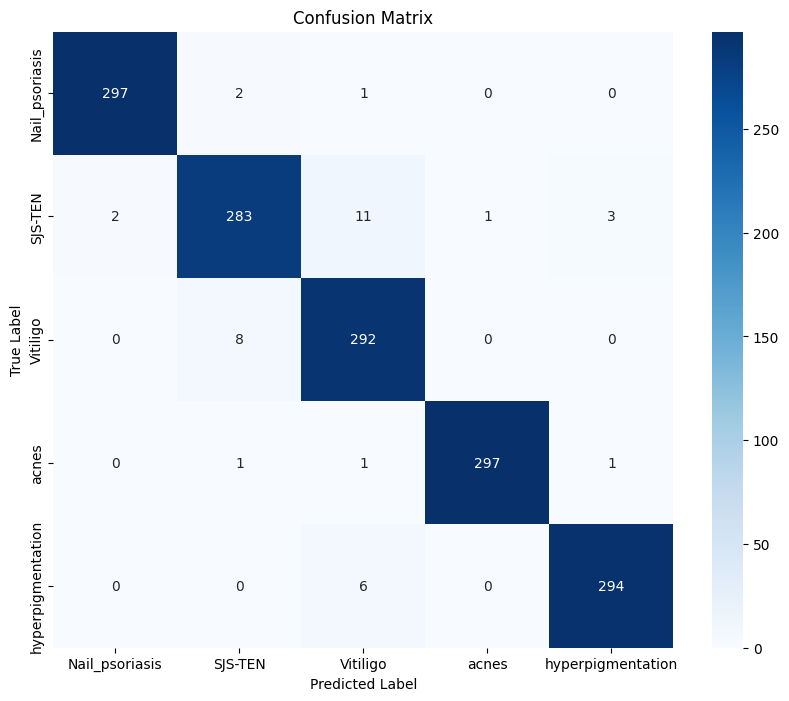

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. Get Predictions and True Labels ---

# Ensure the test generator is not shuffling the data
test_generator.reset()

# Predict the output for the test set
# The model.predict() function will return the probability for each class
y_pred_probs = model.predict(
    test_generator,
    # FIX: Convert the result to an integer
    steps=int(np.ceil(test_generator.samples / test_generator.batch_size))
)

# Convert the probabilities to a single predicted class index
# np.argmax finds the index of the highest probability
y_pred = np.argmax(y_pred_probs, axis=1)

# Get the true labels from the generator
y_true = test_generator.classes

# Get the class names from the generator
class_names = list(test_generator.class_indices.keys())


# --- 2. Generate Classification Report ---
# This report includes precision, recall, and f1-score for each class

print("\n## Classification Report ##\n")
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)


# --- 3. Plot Confusion Matrix ---

print("\n## Confusion Matrix ##\n")

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


**MobileNetv2**

Found 7000 images belonging to 5 classes.
Found 1500 images belonging to 5 classes.
Found 1500 images belonging to 5 classes.
Found 5 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

--- Starting Initial Training (Feature Extraction) ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.4429 - loss: 1.5420 - val_accuracy: 0.7753 - val_loss: 0.5852
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.7198 - loss: 0.7579 - val_accuracy: 0.8433 - val_loss: 0.4521
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.7651 - loss: 0.6235 - val_accuracy: 0.8627 - val_loss: 0.3986
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.7729 - loss: 0.6014 - val_accuracy: 0.8800 - val_loss: 0.3769
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.7942 - loss: 0.5591 - val_accuracy: 0.8860 - val_loss: 0.3402
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.8054 - loss: 0.5147 - val_accuracy: 0.8867 - val_loss: 0.3470
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 110s 1000ms/step - accuracy: 0.8072 - loss: 0.5145 - val_accuracy: 0.8800 - val_loss: 0.3450
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.8143 - loss: 0.4847 - val_

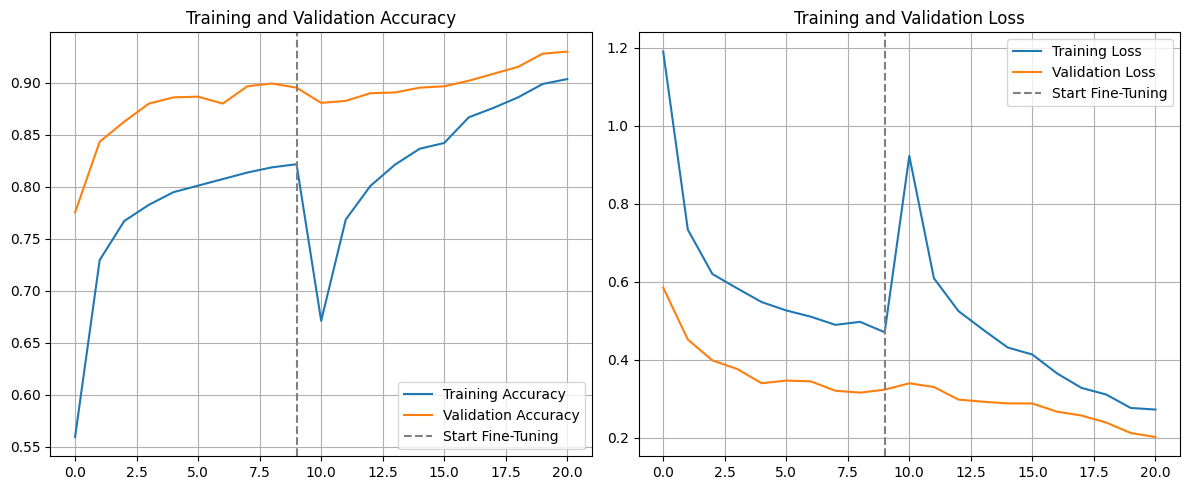

In [ ]:
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import MobileNetV2

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

import os

# --- 1. SETUP FOR SPEED: MIXED PRECISION ---

tf.keras.mixed_precision.set_global_policy('mixed_float16')

# --- 2. Configuration and Setup ---

# Define paths to your split dataset

base_dir = '/content/drive/MyDrive/Thesis/Split_Dataset'

train_dir = os.path.join(base_dir, 'train')

validation_dir = os.path.join(base_dir, 'validation')

test_dir = os.path.join(base_dir, 'test')

# Model parameters

IMG_HEIGHT = 224

IMG_WIDTH = 224

BATCH_SIZE = 64 # Larger batch size for faster training

INITIAL_EPOCHS = 10

FINE_TUNE_EPOCHS = 10

TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS

# --- 3. Data Loading and Preprocessing ---

# Create ImageDataGenerators with MobileNetV2-specific preprocessing

train_datagen = ImageDataGenerator(

    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,

    rotation_range=40,

    width_shift_range=0.2,

    height_shift_range=0.2,

    shear_range=0.2,

    zoom_range=0.2,

    horizontal_flip=True,

    fill_mode='nearest'

)

validation_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

# Create data generators from directories

train_generator = train_datagen.flow_from_directory(

    train_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode='sparse')

validation_generator = validation_datagen.flow_from_directory(

    validation_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode='sparse')

test_generator = test_datagen.flow_from_directory(

    test_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode='sparse', shuffle=False)

num_classes = train_generator.num_classes

print(f"Found {num_classes} classes.")

# --- 4. Model Building (Transfer Learning with MobileNetV2) ---

# Load the MobileNetV2 base model

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze the base model

base_model.trainable = False

# Create our custom classifier head

x = base_model.output

x = GlobalAveragePooling2D()(x)

x = Dropout(0.5)(x)

# Set the final layer's dtype to float32 for numerical stability

predictions = Dense(num_classes, activation='softmax', dtype='float32')(x)

# Combine the base model and our custom head

model = Model(inputs=base_model.input, outputs=predictions)

# --- 5. Compile and Train (Feature Extraction) ---

# Wrap the optimizer in a LossScaleOptimizer for mixed precision

optimizer = tf.keras.mixed_precision.LossScaleOptimizer(Adam(learning_rate=0.001))

model.compile(optimizer=optimizer,

              loss='sparse_categorical_crossentropy',

              metrics=['accuracy'])

print("\n--- Starting Initial Training (Feature Extraction) ---")

history = model.fit(

    train_generator,

    epochs=INITIAL_EPOCHS,

    validation_data=validation_generator

)

# --- 6. Fine-Tuning Phase ---

print("\n--- Starting Fine-Tuning ---")

base_model.trainable = True

# MobileNetV2 has 154 layers. Let's unfreeze from layer 100 onwards.

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:

    layer.trainable = False

# Re-compile with the LossScaleOptimizer for fine-tuning

optimizer_fine = tf.keras.mixed_precision.LossScaleOptimizer(Adam(learning_rate=1e-5))

model.compile(optimizer=optimizer_fine,

              loss='sparse_categorical_crossentropy',

              metrics=['accuracy'])

history_fine = model.fit(

    train_generator,

    epochs=TOTAL_EPOCHS,

    initial_epoch=history.epoch[-1],

    validation_data=validation_generator

)

# --- 7. Final Evaluation ---

print("\n--- Evaluating Model on Test Data ---")

test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Accuracy: {test_accuracy*100:.2f}%")

print(f"Test Loss: {test_loss:.4f}")

# --- 8. Plotting History ---

acc = history.history['accuracy'] + history_fine.history['accuracy']

val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

loss = history.history['loss'] + history_fine.history['loss']

val_loss = history.history['val_loss'] + history_fine.history['val_loss']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)

plt.plot(acc, label='Training Accuracy')

plt.plot(val_acc, label='Validation Accuracy')

plt.axvline(INITIAL_EPOCHS - 1, color='gray', linestyle='--', label='Start Fine-Tuning')

plt.title('Training and Validation Accuracy')

plt.legend()

plt.grid(True)

plt.subplot(1, 2, 2)

plt.plot(loss, label='Training Loss')

plt.plot(val_loss, label='Validation Loss')

plt.axvline(INITIAL_EPOCHS - 1, color='gray', linestyle='--', label='Start Fine-Tuning')

plt.title('Training and Validation Loss')

plt.legend()

plt.grid(True)

plt.tight_layout()

plt.show()


**ConfusionMatrix**

24/24 ━━━━━━━━━━━━━━━━━━━━ 32s 861ms/step

## Classification Report ##

                   precision    recall  f1-score   support

   Nail_psoriasis       0.95      0.98      0.97       300
          SJS-TEN       0.96      0.83      0.89       300
         Vitiligo       0.92      0.84      0.88       300
            acnes       0.84      1.00      0.91       300
hyperpigmentation       0.93      0.93      0.93       300

         accuracy                           0.92      1500
        macro avg       0.92      0.92      0.91      1500
     weighted avg       0.92      0.92      0.91      1500


## Confusion Matrix ##



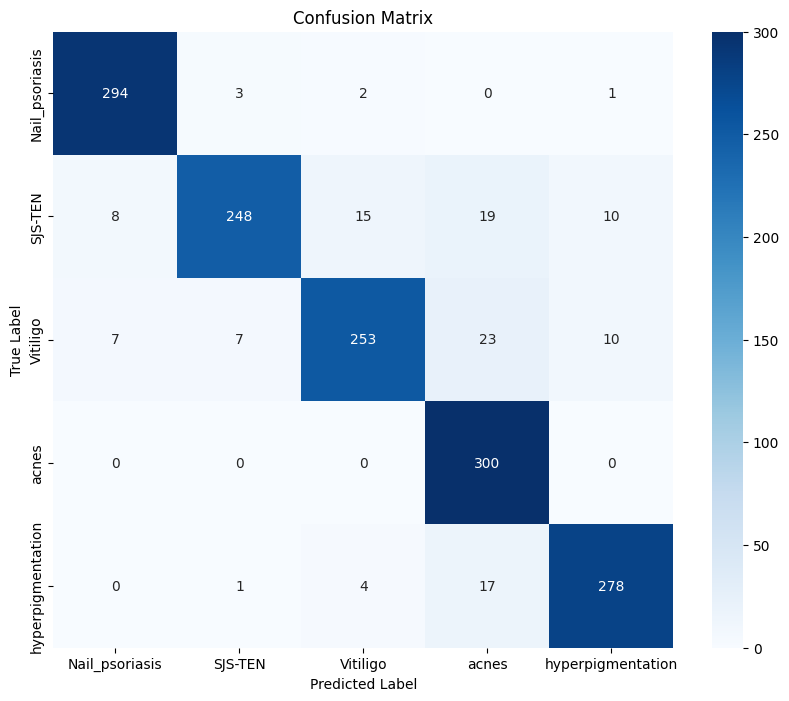

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. Get Predictions and True Labels ---

# Ensure the test generator is not shuffling the data
test_generator.reset()

# Predict the output for the test set
# The model.predict() function will return the probability for each class
y_pred_probs = model.predict(
    test_generator,
    # FIX: Convert the result to an integer
    steps=int(np.ceil(test_generator.samples / test_generator.batch_size))
)

# Convert the probabilities to a single predicted class index
# np.argmax finds the index of the highest probability
y_pred = np.argmax(y_pred_probs, axis=1)

# Get the true labels from the generator
y_true = test_generator.classes

# Get the class names from the generator
class_names = list(test_generator.class_indices.keys())


# --- 2. Generate Classification Report ---
# This report includes precision, recall, and f1-score for each class

print("\n## Classification Report ##\n")
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)


# --- 3. Plot Confusion Matrix ---

print("\n## Confusion Matrix ##\n")

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


**COPY**

In [3]:
import os
import shutil
from tqdm import tqdm

# Path to your dataset on Google Drive
drive_dataset_path = "/content/drive/MyDrive/Thesis/Split_Dataset"
# Path where you want to copy locally (Colab's fast storage)
local_dataset_path = "/content/dataset/Split_Dataset"

# Remove any old copy if exists
if os.path.exists(local_dataset_path):
    shutil.rmtree(local_dataset_path)

# Copy dataset from Drive to Colab local storage
print("Copying dataset from Drive to local storage...")
shutil.copytree(drive_dataset_path, local_dataset_path)

print("✅ Dataset copied to:", local_dataset_path)


Copying dataset from Drive to local storage...
✅ Dataset copied to: /content/dataset/Split_Dataset


**MREN MULTI RESOLUTION ENSEMBLE NETWORK**

Found 7000 images belonging to 5 classes.
Found 7000 images belonging to 5 classes.
Found 1500 images belonging to 5 classes.
Found 1500 images belonging to 5 classes.
Found 1500 images belonging to 5 classes.

--------------------
Dataset Verification:
Training Set:   Found 7000 images belonging to 5 classes.
Validation Set: Found 1500 images belonging to 5 classes.
Testing Set:    Found 1500 images belonging to 5 classes.
--------------------

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

--- Starting Initial Training (Training the Meta-Learner) ---
Epoch 1/8
110/110 ━━━━━━━━━━━━━━━━━━━━ 294s 2s/step - accuracy: 0.6306 - loss: 1.5795 - val_accuracy: 0.9180 - val_loss: 0.2438
Epoch 2/8
110/110 ━━━━━━━━━━━━━━━━━━━━ 58s 532ms/step - accuracy: 0.9014 - loss: 0.2847 - val_accuracy: 0.9433 - val_loss: 0.1859
Epoch 3/8
110/110 ━━━━━━━━━━━━━━━━━━━━ 58s 531ms/step - accuracy: 0.9291 - l

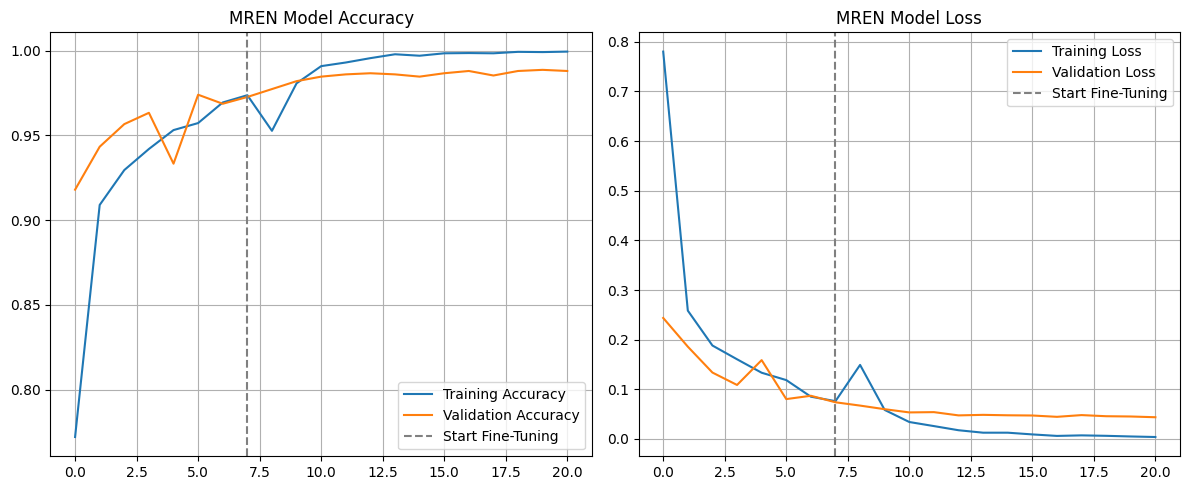

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, InceptionV3, EfficientNetB0
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os
import time
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. SETUP & CONFIGURATION ---
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Set paths to the local copy of the dataset
base_dir = '/content/dataset/Split_Dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Model parameters
IMG_SIZE_224 = 224
IMG_SIZE_299 = 299
BATCH_SIZE = 64
INITIAL_EPOCHS = 8
FINE_TUNE_EPOCHS = 12
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS

# --- 2. OPTIMIZED Data Pipeline with tf.data.Dataset ---
train_datagen_224 = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)
train_datagen_299 = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)
val_datagen_224 = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)
val_datagen_299 = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)

train_flow_224 = train_datagen_224.flow_from_directory(
    train_dir, target_size=(IMG_SIZE_224, IMG_SIZE_224), batch_size=BATCH_SIZE, class_mode='sparse', shuffle=True)
train_flow_299 = train_datagen_299.flow_from_directory(
    train_dir, target_size=(IMG_SIZE_299, IMG_SIZE_299), batch_size=BATCH_SIZE, class_mode='sparse', shuffle=True)
val_flow_224 = val_datagen_224.flow_from_directory(
    validation_dir, target_size=(IMG_SIZE_224, IMG_SIZE_224), batch_size=BATCH_SIZE, class_mode='sparse', shuffle=False)
val_flow_299 = val_datagen_299.flow_from_directory(
    validation_dir, target_size=(IMG_SIZE_299, IMG_SIZE_299), batch_size=BATCH_SIZE, class_mode='sparse', shuffle=False)

# --- ⭐️ DATASET VERIFICATION ---
# Create a temporary generator for the test set to verify its contents
test_datagen_verify = ImageDataGenerator()
test_flow_verify = test_datagen_verify.flow_from_directory(
    test_dir, target_size=(IMG_SIZE_224, IMG_SIZE_224), batch_size=BATCH_SIZE, class_mode='sparse')

print("\n--------------------")
print("Dataset Verification:")
print(f"Training Set:   Found {train_flow_224.samples} images belonging to {train_flow_224.num_classes} classes.")
print(f"Validation Set: Found {val_flow_224.samples} images belonging to {val_flow_224.num_classes} classes.")
print(f"Testing Set:    Found {test_flow_verify.samples} images belonging to {test_flow_verify.num_classes} classes.")
print("--------------------\n")

# Continue with the tf.data.Dataset pipeline for training
def multi_input_generator(gen224, gen299):
    while True:
        X1, y1 = next(gen224)
        X2, y2 = next(gen299)
        yield (X1, X2), y1

output_signature = (
    (tf.TensorSpec(shape=(None, IMG_SIZE_224, IMG_SIZE_224, 3), dtype=tf.float16),
     tf.TensorSpec(shape=(None, IMG_SIZE_299, IMG_SIZE_299, 3), dtype=tf.float16)),
    tf.TensorSpec(shape=(None,), dtype=tf.float32)
)

train_dataset = tf.data.Dataset.from_generator(
    lambda: multi_input_generator(train_flow_224, train_flow_299),
    output_signature=output_signature).prefetch(tf.data.AUTOTUNE)
validation_dataset = tf.data.Dataset.from_generator(
    lambda: multi_input_generator(val_flow_224, val_flow_299),
    output_signature=output_signature).prefetch(tf.data.AUTOTUNE)

num_classes = train_flow_224.num_classes

# --- 3. Building the MREN Model ---
input_224 = Input(shape=(IMG_SIZE_224, IMG_SIZE_224, 3), name='input_224')
input_299 = Input(shape=(IMG_SIZE_299, IMG_SIZE_299, 3), name='input_299')

resnet_base = ResNet50(weights='imagenet', include_top=False, input_tensor=input_224, name='resnet50')
resnet_base.trainable = False
effnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=input_224, name='efficientnetb0')
effnet_base.trainable = False
inception_base = InceptionV3(weights='imagenet', include_top=False, input_tensor=input_299, name='inception_v3')
inception_base.trainable = False

out_resnet = GlobalAveragePooling2D(name='gap_resnet')(resnet_base.output)
out_effnet = GlobalAveragePooling2D(name='gap_effnet')(effnet_base.output)
out_inception = GlobalAveragePooling2D(name='gap_inception')(inception_base.output)

concat_features = Concatenate(name='concat_features')([out_resnet, out_effnet, out_inception])
meta_dense_1 = Dense(512, activation='relu', name='meta_dense_1')(concat_features)
meta_dropout_1 = Dropout(0.5, name='meta_dropout_1')(meta_dense_1)
final_predictions = Dense(num_classes, activation='softmax', dtype='float32', name='final_predictions')(meta_dropout_1)

mren_model = Model(inputs=[input_224, input_299], outputs=final_predictions, name="MREN_Model")
base_models = [resnet_base, effnet_base, inception_base]

# --- 4. Compile and Train (Feature Extraction) ---
optimizer = tf.keras.mixed_precision.LossScaleOptimizer(Adam(learning_rate=0.001))
mren_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("\n--- Starting Initial Training (Training the Meta-Learner) ---")
history = mren_model.fit(
    train_dataset,
    steps_per_epoch=len(train_flow_224),
    epochs=INITIAL_EPOCHS,
    validation_data=validation_dataset,
    validation_steps=len(val_flow_224)
)

# --- 5. FULL FINE-TUNING PHASE ---
print("\n--- Starting Fine-Tuning (All Three Models) ---")
for base_model in base_models:
    base_model.trainable = True
    if 'resnet' in base_model.name: fine_tune_at = 143
    elif 'efficientnet' in base_model.name: fine_tune_at = -30
    else: fine_tune_at = 249

    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

optimizer_fine = tf.keras.mixed_precision.LossScaleOptimizer(Adam(learning_rate=1e-5))
mren_model.compile(optimizer=optimizer_fine, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_fine = mren_model.fit(
    train_dataset,
    steps_per_epoch=len(train_flow_224),
    epochs=TOTAL_EPOCHS,
    initial_epoch=history.epoch[-1],
    validation_data=validation_dataset,
    validation_steps=len(val_flow_224)
)

# --- 6. Plotting Training History ---
print("\n--- Plotting Training and Validation History ---")
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.axvline(INITIAL_EPOCHS - 1, color='gray', linestyle='--', label='Start Fine-Tuning')
plt.title('MREN Model Accuracy')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(INITIAL_EPOCHS - 1, color='gray', linestyle='--', label='Start Fine-Tuning')
plt.title('MREN Model Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Confusion matrix and evaluation**

Found 1500 images belonging to 5 classes.
Found 1500 images belonging to 5 classes.

--- Generating predictions on the test set... ---
24/24 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step

Keras Class Mapping: {'Nail_psoriasis': 0, 'SJS-TEN': 1, 'Vitiligo': 2, 'acnes': 3, 'hyperpigmentation': 4}
Correctly Ordered Labels for Report: ['Nail_psoriasis', 'SJS-TEN', 'Vitiligo', 'acnes', 'hyperpigmentation']

## Classification Report ##

                   precision    recall  f1-score   support

   Nail_psoriasis       0.99      0.99      0.99       300
          SJS-TEN       0.98      0.97      0.97       300
         Vitiligo       0.98      0.97      0.97       300
            acnes       1.00      1.00      1.00       300
hyperpigmentation       0.98      1.00      0.99       300

         accuracy                           0.98      1500
        macro avg       0.98      0.98      0.98      1500
     weighted avg       0.98      0.98      0.98      1500


## Confusion Matrix ##



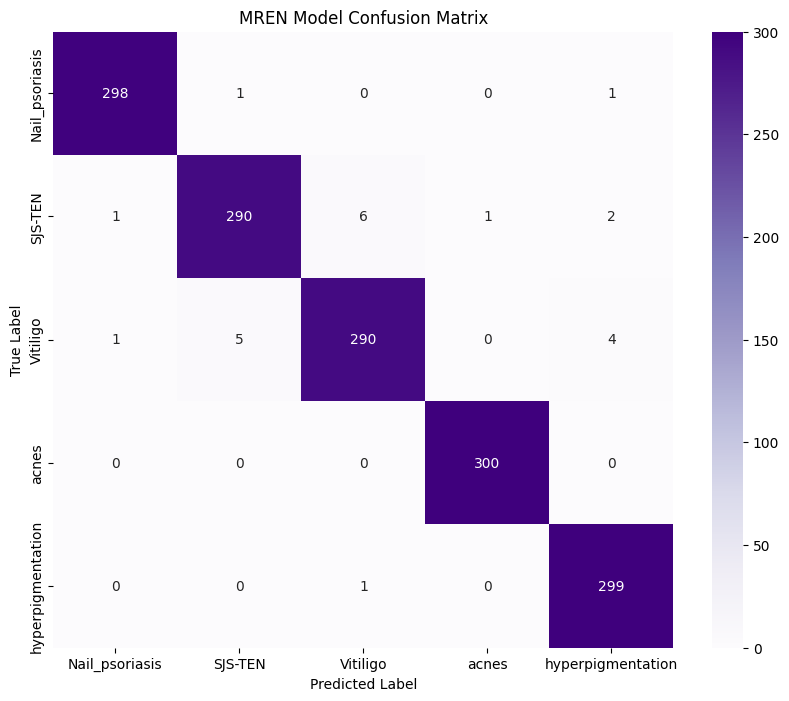

In [5]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import os

# --- 1. Configuration and Test Data Pipeline Setup ---
# This section re-creates the data pipeline for the test set.
# NOTE: Ensure these variables match your training script.

# Set paths to the local copy of the dataset
base_dir = '/content/dataset/Split_Dataset'
test_dir = os.path.join(base_dir, 'test')

# Model parameters
IMG_SIZE_224 = 224
IMG_SIZE_299 = 299
BATCH_SIZE = 64

# Create two separate data flows for the two required image sizes
# shuffle=False is critical for evaluation
test_datagen_224 = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)
test_datagen_299 = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)

test_flow_224 = test_datagen_224.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE_224, IMG_SIZE_224),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False)

test_flow_299 = test_datagen_299.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE_299, IMG_SIZE_299),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False)

# Custom Python generator that yields the multi-input data
def multi_input_generator(gen224, gen299):
    while True:
        X1, y1 = next(gen224)
        X2, y2 = next(gen299)
        yield (X1, X2), y1

# Define the data signature for TensorFlow
output_signature = (
    (tf.TensorSpec(shape=(None, IMG_SIZE_224, IMG_SIZE_224, 3), dtype=tf.float16),
     tf.TensorSpec(shape=(None, IMG_SIZE_299, IMG_SIZE_299, 3), dtype=tf.float16)),
    tf.TensorSpec(shape=(None,), dtype=tf.float32)
)

# Convert the Python generator into an optimized tf.data.Dataset
test_dataset = tf.data.Dataset.from_generator(
    lambda: multi_input_generator(test_flow_224, test_flow_299),
    output_signature=output_signature
).prefetch(tf.data.AUTOTUNE)

# --- 2. Get Model Predictions ---
print("\n--- Generating predictions on the test set... ---")

# Calculate the number of steps needed to cover the entire test set
test_steps = len(test_flow_224)

# Get predictions from the trained MREN model
y_pred_probs = mren_model.predict(test_dataset, steps=test_steps)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get the true labels
y_true = test_flow_224.classes

# Ensure prediction array has the correct length
y_pred = y_pred[:len(y_true)]

# --- 3. FIX: Create Correctly Ordered Class Labels ---
# This step prevents the cyclical error in the confusion matrix

class_indices = test_flow_224.class_indices
# Sort the dictionary by its integer value (0, 1, 2...)
sorted_indices = sorted(class_indices.items(), key=lambda item: item[1])
# Create a new list of names in the correct order
correctly_ordered_class_names = [item[0] for item in sorted_indices]

print("\nKeras Class Mapping:", class_indices)
print("Correctly Ordered Labels for Report:", correctly_ordered_class_names)

# --- 4. Display Evaluation Metrics ---

# Generate and print the classification report
print("\n## Classification Report ##\n")
print(classification_report(y_true, y_pred, target_names=correctly_ordered_class_names))

# Generate and plot the confusion matrix
print("\n## Confusion Matrix ##\n")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=correctly_ordered_class_names,
            yticklabels=correctly_ordered_class_names)
plt.title('MREN Model Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [6]:
!pip install opencv-python


**XAI**

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator # <-- THE FIX IS HERE
import numpy as np
import matplotlib.pyplot as plt
import cv2 # OpenCV for image processing
import os

# --- 1. The Grad-CAM Algorithm ---

def get_grad_cam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= (tf.math.reduce_max(heatmap) + tf.keras.backend.epsilon())
    return heatmap.numpy()

def superimpose_grad_cam(img, heatmap, alpha=0.4):
    heatmap = np.uint8(255 * heatmap)
    jet = plt.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)
    return superimposed_img

# --- 2. Prepare Image and Main Model Prediction ---

# ⭐️ IMPORTANT: Specify the path to an image from your test set
IMAGE_PATH = '/content/drive/MyDrive/Thesis/Split_Dataset/test/acnes/173__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsInkiLDg1XQ.jpg' # <-- CHANGE THIS
os.makedirs("xai_results", exist_ok=True)

original_img = cv2.imread(IMAGE_PATH)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

# Preprocess the image for the two different input sizes
img_224 = tf.keras.utils.load_img(IMAGE_PATH, target_size=(224, 224))
img_array_224 = np.expand_dims(tf.keras.utils.img_to_array(img_224), axis=0)
preprocessed_224 = tf.keras.applications.resnet.preprocess_input(img_array_224.copy())

img_299 = tf.keras.utils.load_img(IMAGE_PATH, target_size=(299, 299))
img_array_299 = np.expand_dims(tf.keras.utils.img_to_array(img_299), axis=0)
preprocessed_299 = tf.keras.applications.inception_v3.preprocess_input(img_array_299.copy())

# Generate the class names list within this script
temp_datagen = ImageDataGenerator()
temp_generator = temp_datagen.flow_from_directory(
    directory=os.path.dirname(os.path.dirname(IMAGE_PATH)), # Gets the '/content/split_dataset/test' directory
    shuffle=False)
class_indices = temp_generator.class_indices
# Sort the dictionary by its integer value (0, 1, 2...) to ensure correct order
sorted_indices = sorted(class_indices.items(), key=lambda item: item[1])
correctly_ordered_class_names = [item[0] for item in sorted_indices]
class_names = correctly_ordered_class_names
print("Class names found and ordered:", class_names)

# Make a prediction with the full MREN model to know which class to explain
preds = mren_model.predict([preprocessed_224, preprocessed_299])
top_pred_index = np.argmax(preds[0])
print(f"MREN model prediction: {class_names[top_pred_index]} with {preds[0][top_pred_index]:.2f} confidence.")

# --- 3. Generate Heatmaps for Each Isolated Base Model ---

# Define the base models and their last conv layers
base_model_info = {
    "ResNet50": (mren_model.get_layer('resnet50'), "conv5_block3_out", preprocessed_224),
    "EfficientNetB0": (mren_model.get_layer('efficientnetb0'), "top_conv", preprocessed_224),
    "InceptionV3": (mren_model.get_layer('inception_v3'), "mixed10", preprocessed_299)
}

for model_name, (base_model, layer_name, preprocessed_input) in base_model_info.items():
    print(f"\n--- Generating Grad-CAM for {model_name} ---")

    # Create a new, simple model from the isolated base model
    temp_model = tf.keras.models.Model(
        base_model.inputs, base_model.outputs
    )

    # Generate the heatmap using this simple, isolated model
    heatmap = get_grad_cam_heatmap(preprocessed_input, temp_model, layer_name)

    # Superimpose the heatmap on the original image
    superimposed_image = superimpose_grad_cam(original_img, heatmap)

    # Save the final image
    save_path = os.path.join("xai_results", f"grad_cam_{model_name}.png")
    superimposed_image.save(save_path)

    # Display the result
    plt.figure(figsize=(8, 8))
    plt.imshow(superimposed_image)
    plt.title(f"Grad-CAM for {model_name}", fontsize=16)
    plt.axis("off")
    plt.show()

print("\n--- XAI analysis complete. Images saved in 'xai_results' directory. ---")

Found 1500 images belonging to 5 classes.
Class names found and ordered: ['Nail_psoriasis', 'SJS-TEN', 'Vitiligo', 'acnes', 'hyperpigmentation']


NameError: name 'mren_model' is not defined